In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import statsmodels.api as sm

# Set a fixed random seed for reproducibility
random.seed(19)

df = pd.read_csv("../data/data_final.csv.gz")
df['date'] = pd.to_datetime(df['date'])
to_pred_df = df.loc[df['date'] >= pd.to_datetime('2017-01-01 00:00:00')].reset_index(drop=True)
df = df.loc[df['date'] < pd.to_datetime('2017-01-01 00:00:00')].reset_index(drop=True)

In [ ]:
tiles = df['tile_index'].unique().tolist()
random.shuffle(tiles)

train_ratio = 0.75
split_index = int(train_ratio * len(tiles))
train_tiles = tiles[:split_index] 
test_tiles = tiles[split_index:]  

train_df = df.loc[df['tile_index'].isin(train_tiles)]
test_df = df.loc[df['tile_index'].isin(test_tiles)]

X_cols = [col for col in df.columns if col.startswith('feature')]
y_col = 'avg_urban_imperviousness'
X_train = train_df[X_cols]
y_train = train_df[y_col]
X_test = test_df[X_cols]
y_test = test_df[y_col]

In [7]:
X_train.shape

(13395, 768)

In [11]:
print(y_train.describe())

       avg_urban_imperviousness
count              13395.000000
mean                   3.210876
std                    5.788118
min                    0.000000
25%                    0.366940
50%                    1.387734
75%                    3.229994
max                   59.641462


**Training Data Context**:

  - The mean value of the target variable, `avg_urban_imperviousness`, is approximately 3.21, with a relatively 
    high standard deviation of 5.79.
  -  The data distribution is skewed, with the 75th percentile at 3.23 and a maximum value of 59.64. This suggests 
    that while most values are concentrated at the lower end, there are significant outliers with high imperviousness.

In [ ]:
# Create the directory path for storing the models
models_dir = "../artifacts/models"
os.makedirs(models_dir, exist_ok=True)

# Dictionary of models to save
model_names = {
    'random_forest': rf_best,
    'lightgbm': lgb_best
}


In [14]:
# Establish a baseline model using the mean
baseline_pred = np.full_like(y_test, y_train.mean().values, dtype=np.float64)

# Calculate baseline performance
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_r2 = r2_score(y_test, baseline_pred)
print(f"Baseline RMSE: {baseline_rmse:.4f}")
print(f"Baseline R^2: {baseline_r2:.4f}")

Baseline RMSE: 5.7381
Baseline R^2: -0.0002


In [27]:
# Simple Linear Regression
lr_model_path = os.path.join(models_dir, 'linear_regression.pkl')
if not os.path.exists(lr_model_path):
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    with open(lr_model_path, 'wb') as f:
        pickle.dump(lr_model, f)
else:
    with open(lr_model_path, 'rb') as f:
        lr_model = pickle.load(f)
lr_pred = lr_model.predict(X_test)

# Evaluate Linear Regression model
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)
print(f"Linear Regression RMSE: {lr_rmse:.4f}")
print(f"Linear Regression R^2: {lr_r2:.4f}")

Linear Regression RMSE: 2.5847
Linear Regression R^2: 0.7971


In [28]:
# PCA
pca_95n_path = os.path.join(models_dir, 'pca_95n.pkl')
if not os.path.exists(pca_95n_path):
    pca = PCA(n_components=0.95)  # Retain 95% of the variance
    X_train_pca = pca.fit_transform(X_train)
    with open(pca_95n_path, 'wb') as f:
        pickle.dump(pca, f)
else:
    with open(pca_95n_path, 'rb') as f:
        pca = pickle.load(f)
        X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [29]:
# PCA + Linear Regression
lr_pca_model_path = os.path.join(models_dir, 'pca_linear_regression.pkl')
if not os.path.exists(lr_model_path):
    lr_pca_model = LinearRegression()
    lr_pca_model.fit(X_train_pca, y_train)
    with open(lr_pca_model_path, 'wb') as f:
        pickle.dump(lr_pca_model, f)
else:
    with open(lr_pca_model_path, 'rb') as f:
        lr_pca_model = pickle.load(f)
lr_pca_pred = lr_pca_model.predict(X_test_pca)

# Evaluate PCA + Linear Regression model
lr_pca_rmse = np.sqrt(mean_squared_error(y_test, lr_pca_pred))
lr_pca_r2 = r2_score(y_test, lr_pca_pred)
print(f"PCA + Linear Regression RMSE: {lr_pca_rmse:.4f}")
print(f"PCA + Linear Regression R^2: {lr_pca_r2:.4f}")

PCA + Linear Regression RMSE: 2.6655
PCA + Linear Regression R^2: 0.7842


In [26]:
# LASSO Regression with Cross-Validation
lasso_model_path = os.path.join(models_dir, 'lasso_regression.pkl')
if not os.path.exists(lasso_model_path):
    lasso_model = LassoCV(alphas=np.logspace(-4, 0, 50), cv=5)
    lasso_model.fit(X_train, y_train)
    with open(lasso_model_path, 'wb') as f:
        pickle.dump(lasso_model, f)
else:
    with open(lasso_model_path, 'rb') as f:
        lasso_model = pickle.load(f)
lasso_pred = lasso_model.predict(X_test)

# Evaluate LASSO model
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))
lasso_r2 = r2_score(y_test, lasso_pred)
print(f"LASSO Regression RMSE: {lasso_rmse:.4f}")
print(f"LASSO Regression R^2: {lasso_r2:.4f}")
print(f"Optimal alpha for LASSO: {lasso_model.alpha_:.4e}")

LASSO Regression RMSE: 2.5538
LASSO Regression R^2: 0.8019
Optimal alpha for LASSO: 5.4287e-04


In [ ]:
# Random Forest with Cross-Validation for Hyperparameter Tuning
rf_model_path = os.path.join(models_dir, 'random_forest.pkl')
if not os.path.exists(rf_model_path):
    rf_model = RandomForestRegressor(random_state=19)
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    rf_cv = GridSearchCV(
        rf_model,
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        verbose=2
        n_jobs=-1  
    )
    rf_cv.fit(X_train, y_train.values.ravel())
    rf_best = rf_cv.best_estimator_ 
    with open(rf_model_path, 'wb') as f:
        pickle.dump(rf_best, f)
else:
    with open(rf_model_path, 'rb') as f:
        rf_best = pickle.load(f)
rf_pred = rf_best.predict(X_test)

# Evaluate Random Forest model
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)
print(f"Random Forest RMSE: {rf_rmse:.4f}")
print(f"Random Forest R^2: {rf_r2:.4f}")
print(f"Best params for Random Forest: {rf_cv.best_params_}")

In [25]:

# LightGBM with Cross-Validation for Hyperparameter Tuning
lgb_model_path = os.path.join(models_dir, 'lightgbm.pkl')
if not os.path.exists(lgb_model_path):
    lgb_model = LGBMRegressor(random_state=19)
    lgb_param_grid = {
        'num_leaves': [31, 50],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 200]
    }
    lgb_cv = GridSearchCV(lgb_model, lgb_param_grid, cv=5, scoring='neg_mean_squared_error')
    lgb_cv.fit(X_train, y_train.values.ravel())
    lgb_best = lgb_cv.best_estimator_
    with open(lgb_model_path, 'wb') as f:
        pickle.dump(lgb_best, f)
else:
    with open(lgb_model_path, 'rb') as f:
        lgb_best = pickle.load(f)
lgb_pred = lgb_best.predict(X_test)

# Evaluate LightGBM model
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
lgb_r2 = r2_score(y_test, lgb_pred)
print(f"LightGBM RMSE: {lgb_rmse:.4f}")
print(f"LightGBM R^2: {lgb_r2:.4f}")
print(f"Best params for LightGBM: {lgb_cv.best_params_}")


LightGBM RMSE: 2.5986
LightGBM R^2: 0.7949
Best params for LightGBM: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 31}


                     Model      RMSE       R^2
0                 Baseline  5.738143 -0.000176
1        Linear Regression  2.584719  0.797063
2  PCA + Linear Regression  2.665474  0.784184
3         LASSO Regression  2.553823  0.801886
4                 LightGBM  2.598562  0.794884


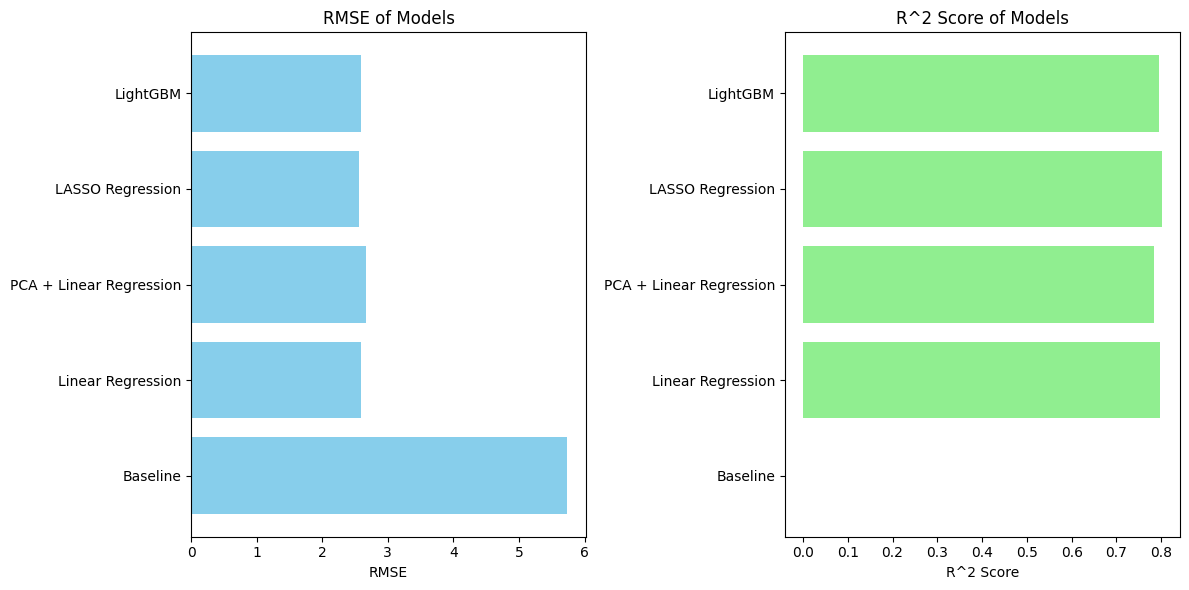

In [ ]:
models = {
    'baseline': baseline_pred,  # Note: this is not a model, just predictions; saving for consistency
    'linear_regression': lr_model,
    'pca_linear_regression': lr_pca_model,
    'lasso_regression': lasso_model,
    'random_forest': rf_best,
    'lightgbm': lgb_best
}

# Create a dictionary to store the model results
results = {
    'Model': ['Baseline', 'Linear Regression', 'PCA + Linear Regression', 'LASSO Regression', 'Random Forest', 'LightGBM'],
    'RMSE': [baseline_rmse, lr_rmse, lr_pca_rmse, lasso_rmse, rf_rmse, lgb_rmse],
    'R^2': [baseline_r2, lr_r2, lr_pca_r2, lasso_r2, rf_r2, lgb_r2]
}

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results)

# Display the results DataFrame
print(results_df)

# Plot the scores for easy comparison
plt.figure(figsize=(12, 6))

# RMSE Plot
plt.subplot(1, 2, 1)
plt.barh(results_df['Model'], results_df['RMSE'], color='skyblue')
plt.xlabel('RMSE')
plt.title('RMSE of Models')

# R^2 Plot
plt.subplot(1, 2, 2)
plt.barh(results_df['Model'], results_df['R^2'], color='lightgreen')
plt.xlabel('R^2 Score')
plt.title('R^2 Score of Models')

plt.tight_layout()
plt.show()

In [35]:
def smape(y_actual, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_actual) / (np.abs(y_actual) + np.abs(y_pred)))

def plot_predictions_vs_actuals(y_actual, y_pred, title="Predictions vs Actuals"):
    plt.figure(figsize=(8, 8))
    plt.scatter(y_actual, y_pred, alpha=0.6)
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)  # Line y=x
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_residuals(y_actual, y_pred, title="Residual Plot"):
    residuals = y_actual - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--', linewidth=2)
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_residual_histogram(y_actual, y_pred, bins=30, title="Histogram of Residuals"):
    residuals = y_actual - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, bins=bins, color='blue', alpha=0.7)
    plt.axvline(0, color='red', linestyle='--', linewidth=2)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.show()

def plot_cdf_of_absolute_errors(y_actual, y_pred, title="Cumulative Distribution of Absolute Errors"):
    abs_errors = np.abs(y_actual - y_pred)
    sorted_errors = np.sort(abs_errors)
    cumulative_distribution = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)

    plt.figure(figsize=(10, 6))
    plt.plot(sorted_errors, cumulative_distribution, marker='.', linestyle='-', color='blue')
    plt.xlabel("Absolute Error")
    plt.ylabel("Cumulative Probability")
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_qq_plot(y_actual, y_pred, title="Q-Q Plot of Residuals"):
    residuals = y_actual - y_pred
    plt.figure(figsize=(8, 8))
    sm.qqplot(residuals, line='s')
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_residuals_boxplot(y_actual, y_pred, title="Box Plot of Residuals"):
    residuals = y_actual - y_pred
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=residuals, orient='h')
    plt.xlabel("Residuals")
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_cooks_distance(X, y, title="Cook's Distance Plot"):
    X_with_const = sm.add_constant(X)  # Add constant for intercept
    model = sm.OLS(y, X_with_const).fit()
    influence = model.get_influence()
    cooks_d = influence.cooks_distance[0]

    plt.figure(figsize=(10, 6))
    plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", basefmt=" ")
    plt.axhline(4 / len(cooks_d), color='red', linestyle='--', label='Threshold Line')
    plt.xlabel("Observation Index")
    plt.ylabel("Cook's Distance")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()


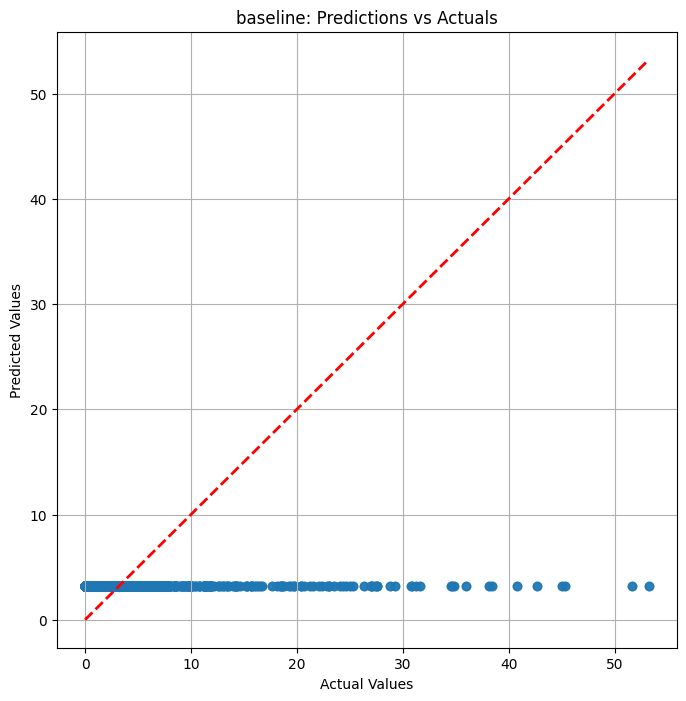

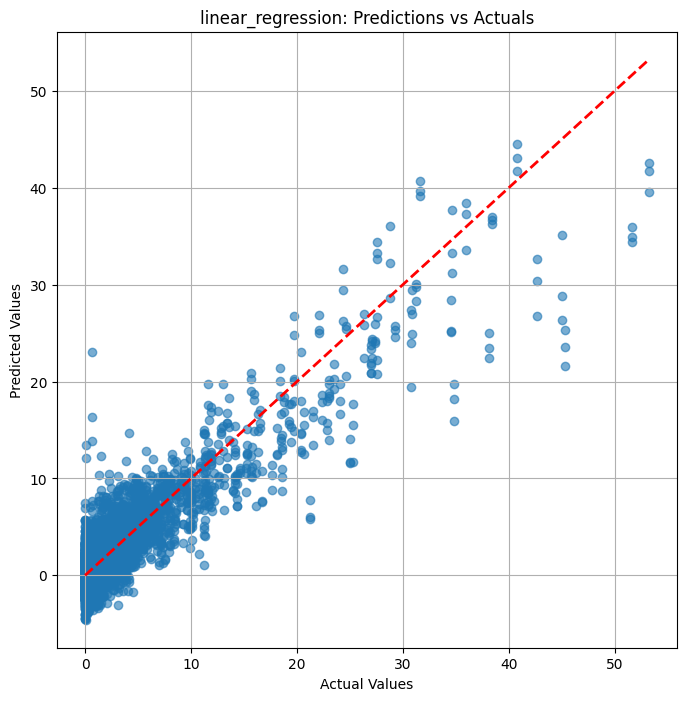

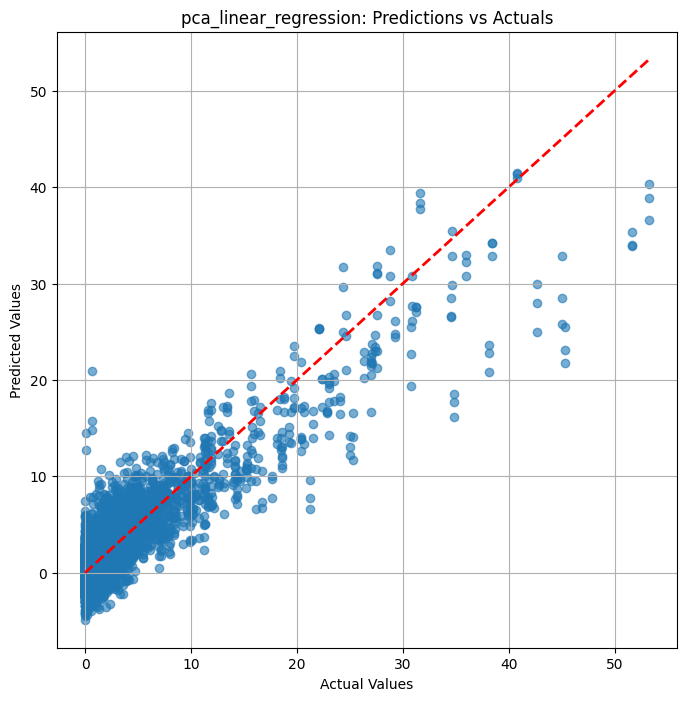

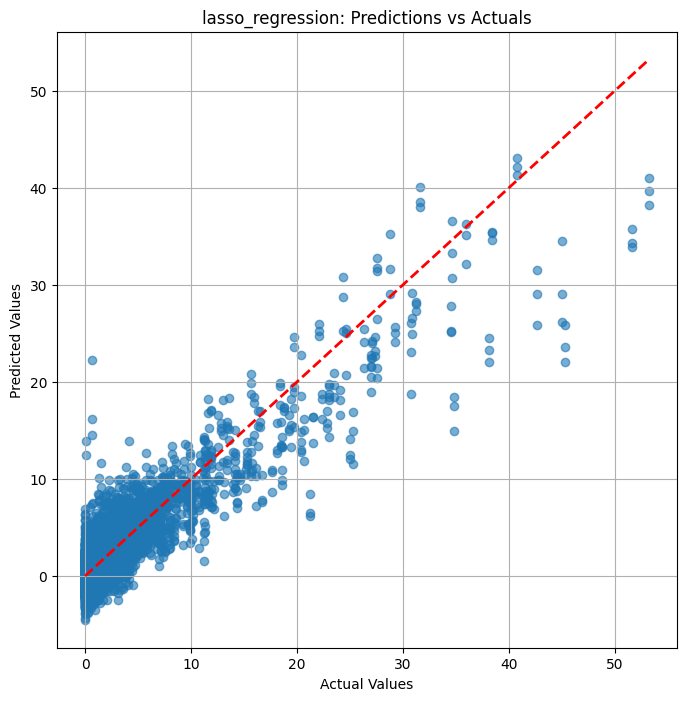

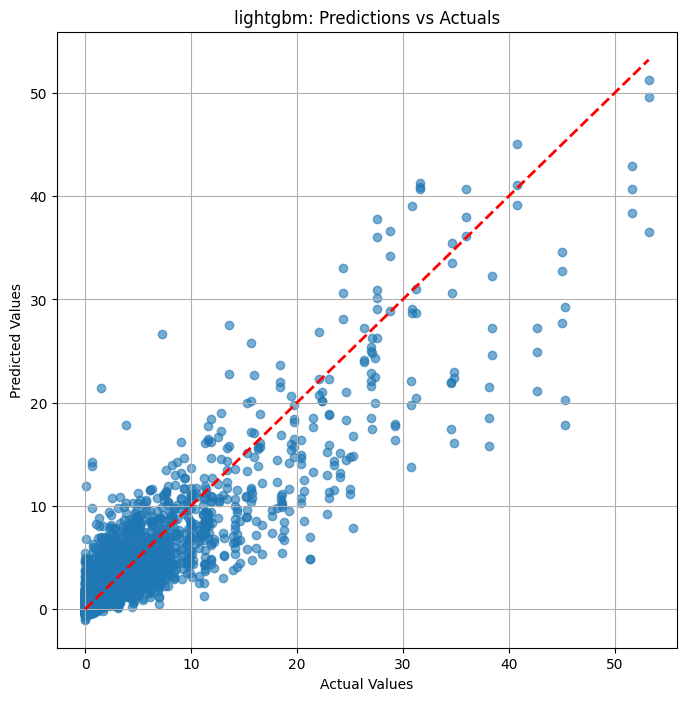

In [37]:
# Scatter plot of predictions vs actuals for all models
for model_name, model in models.items():
    if model_name == 'pca_linear_regression':
        y_pred = model.predict(X_test_pca)
    elif model_name == 'baseline':  
        y_pred = np.full_like(y_test, y_train.mean().values, dtype=np.float64)
    else:
        y_pred = model.predict(X_test)
    plot_predictions_vs_actuals(y_test, y_pred, title=f"{model_name}: Predictions vs Actuals")

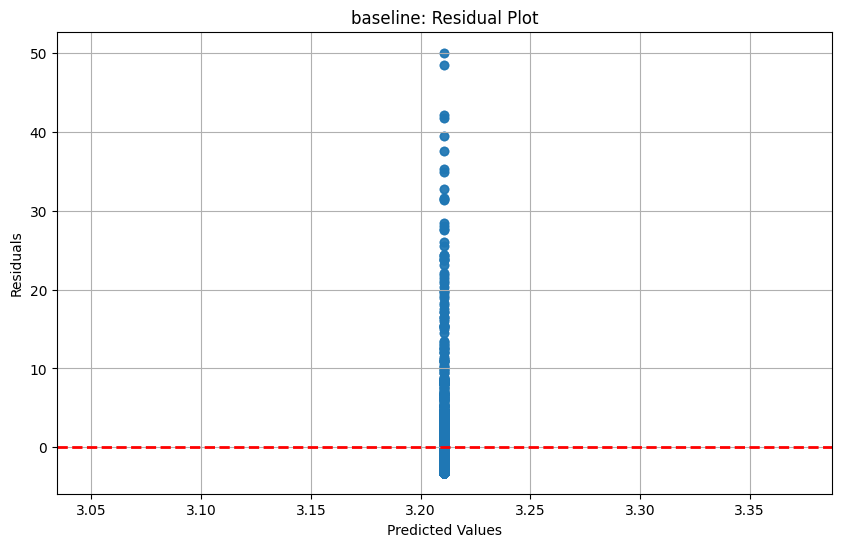

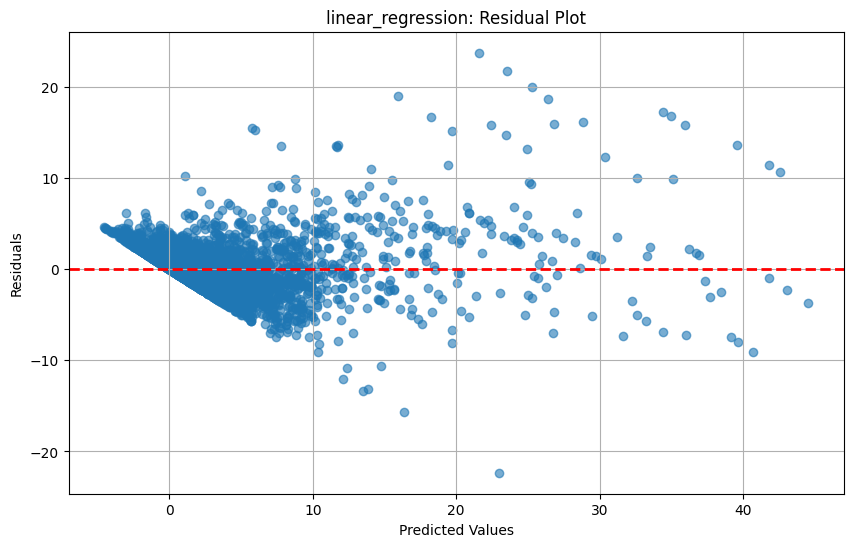

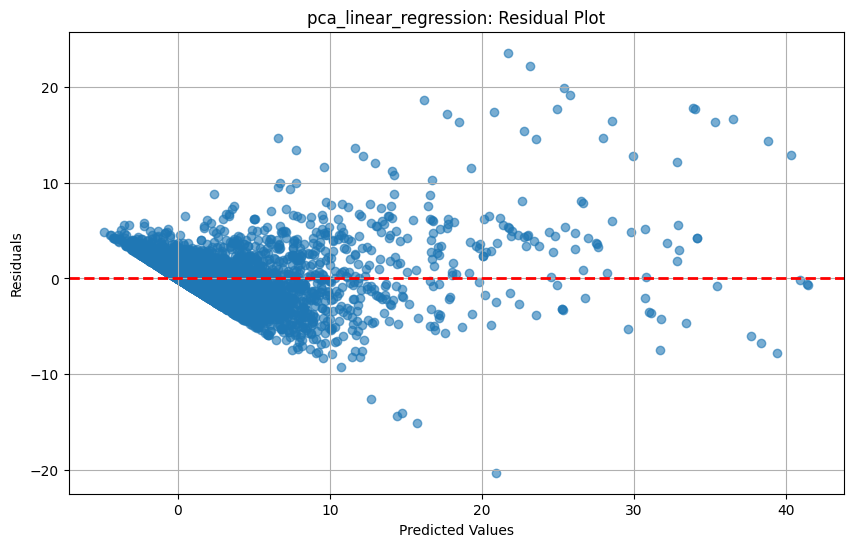

ValueError: Unable to coerce to Series, length must be 1: given 4467

In [38]:
# Residual plot for all models
for model_name, model in models.items():
    if model_name == 'pca_linear_regression':
        y_pred = model.predict(X_test_pca)
    elif model_name == 'baseline':  
        y_pred = np.full_like(y_test, y_train.mean().values, dtype=np.float64)
    else:
        y_pred = model.predict(X_test)
    plot_residuals(y_test, y_pred, title=f"{model_name}: Residual Plot")

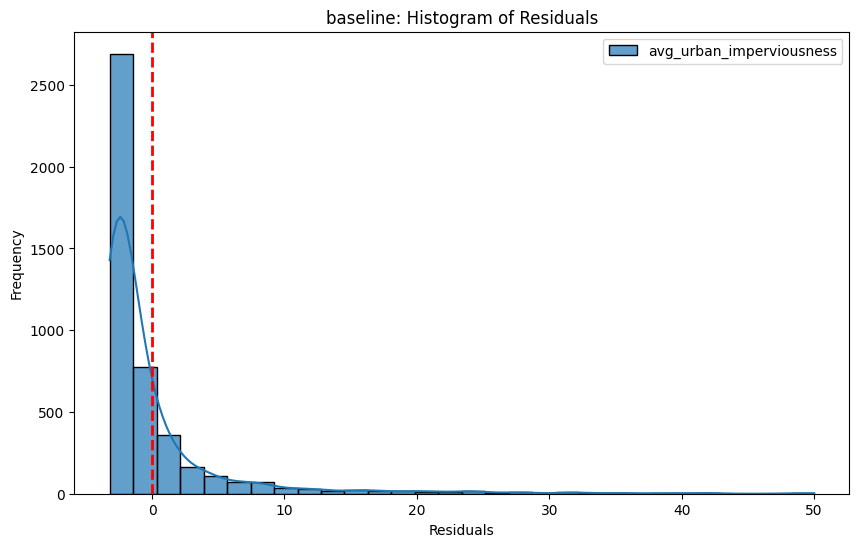

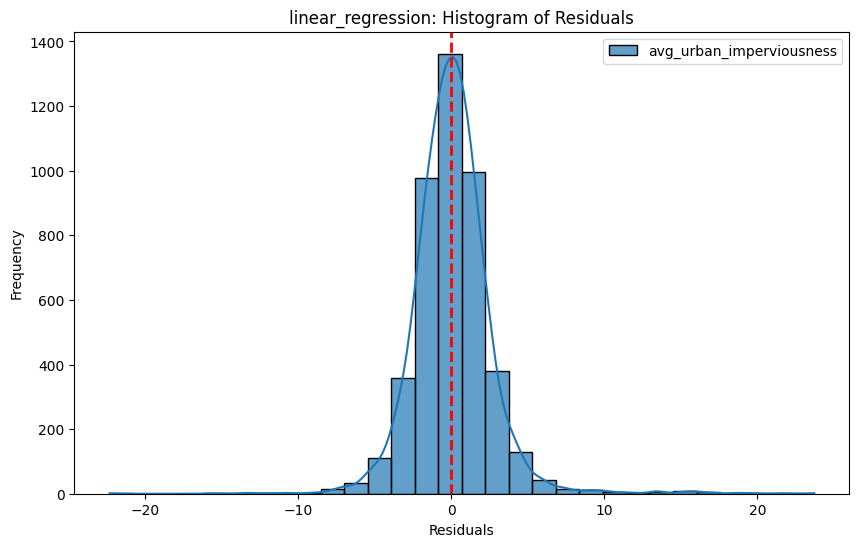

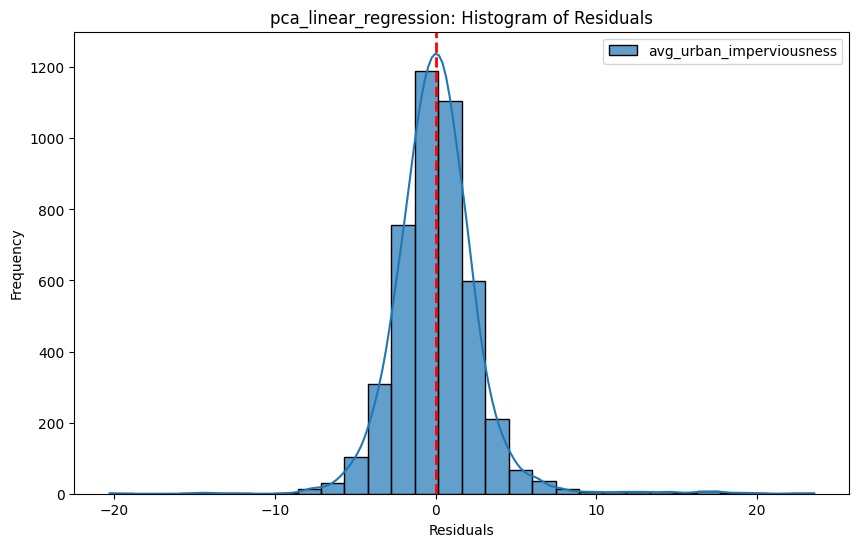

ValueError: Unable to coerce to Series, length must be 1: given 4467

In [39]:
# Histogram of residuals for all models
for model_name, model in models.items():
    if model_name == 'pca_linear_regression':
        y_pred = model.predict(X_test_pca)
    elif model_name == 'baseline':  
        y_pred = np.full_like(y_test, y_train.mean().values, dtype=np.float64)
    else:
        y_pred = model.predict(X_test)
    plot_residual_histogram(y_test, y_pred, title=f"{model_name}: Histogram of Residuals")

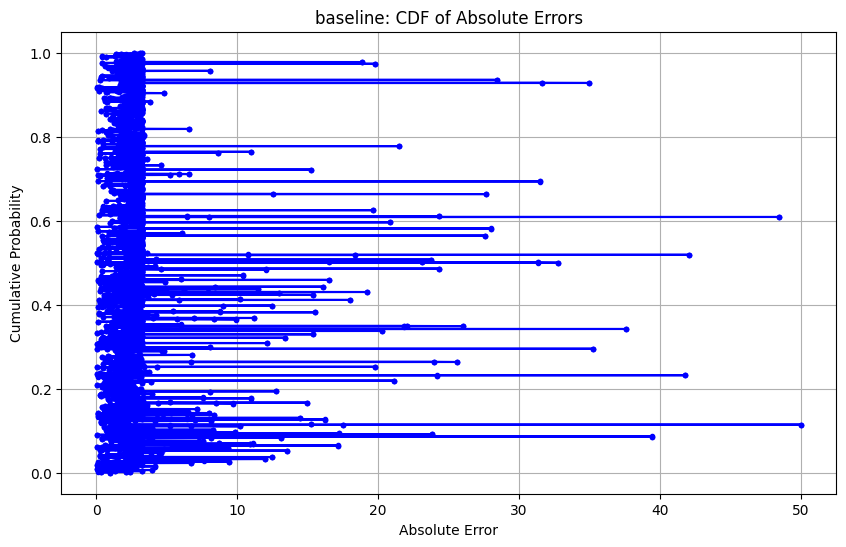

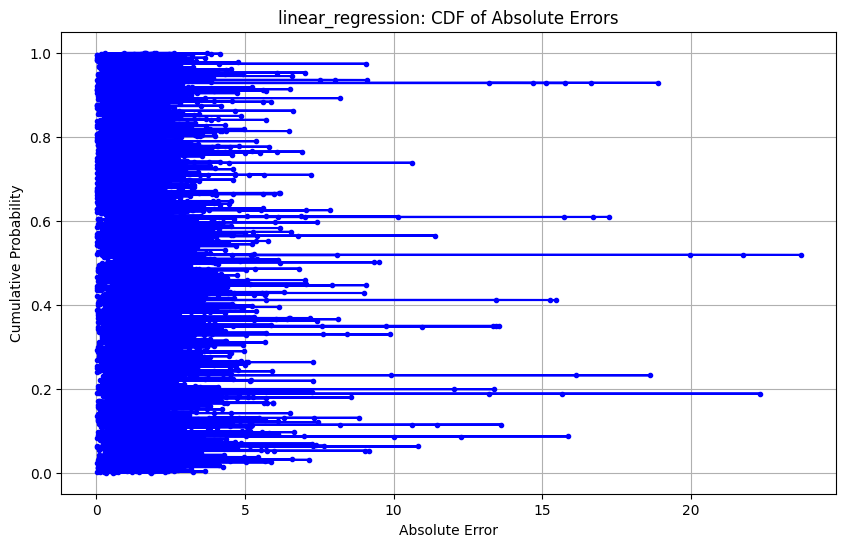

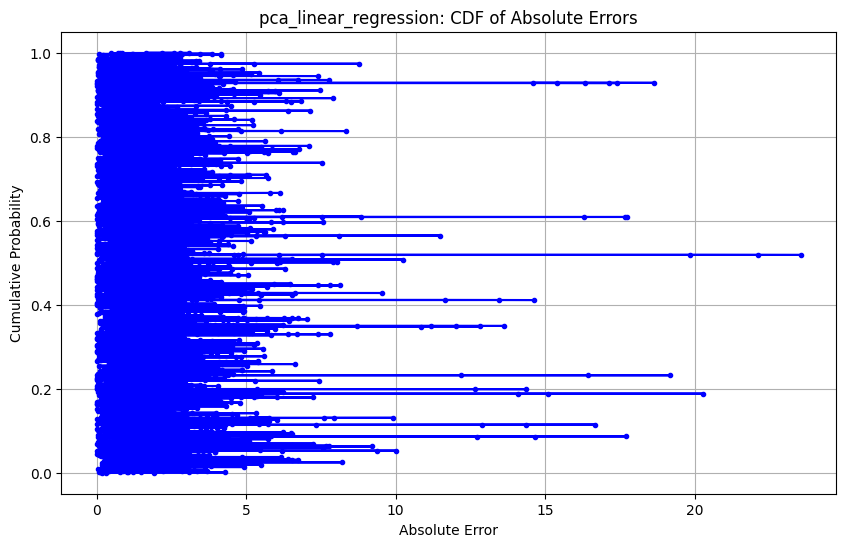

ValueError: Unable to coerce to Series, length must be 1: given 4467

In [40]:
# CDF of absolute errors for all models
for model_name, model in models.items():
    if model_name == 'pca_linear_regression':
        y_pred = model.predict(X_test_pca)
    elif model_name == 'baseline':  
        y_pred = np.full_like(y_test, y_train.mean().values, dtype=np.float64)
    else:
        y_pred = model.predict(X_test) 
    plot_cdf_of_absolute_errors(y_test, y_pred, title=f"{model_name}: CDF of Absolute Errors")

<Figure size 800x800 with 0 Axes>

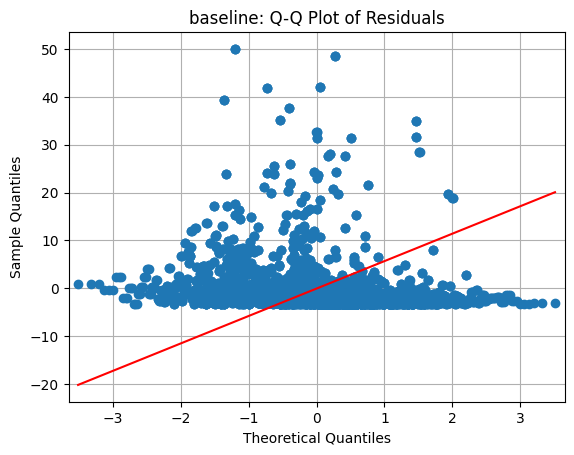

<Figure size 800x800 with 0 Axes>

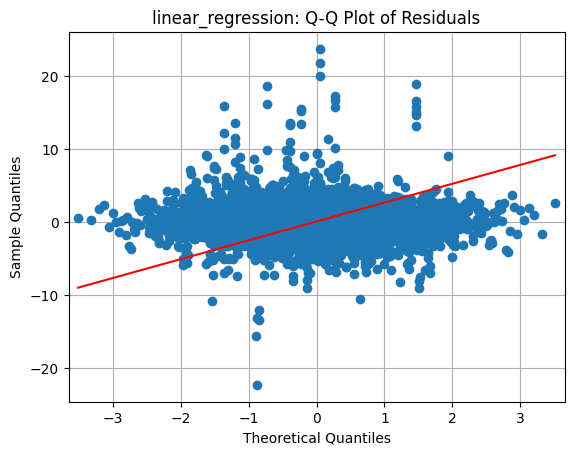

<Figure size 800x800 with 0 Axes>

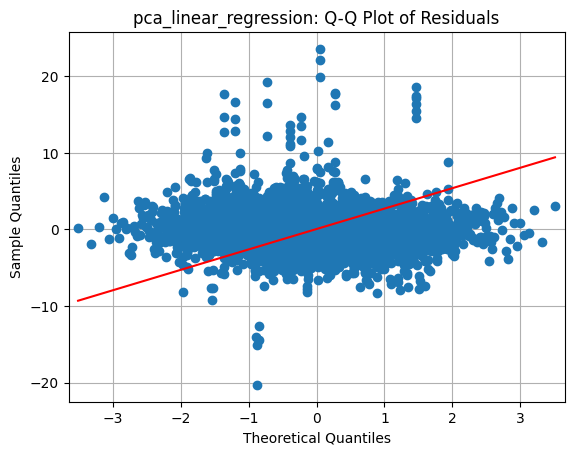

ValueError: Unable to coerce to Series, length must be 1: given 4467

In [41]:
# Q-Q plot for all models
for model_name, model in models.items():
    if model_name == 'pca_linear_regression':
        y_pred = model.predict(X_test_pca)
    elif model_name == 'baseline':  
        y_pred = np.full_like(y_test, y_train.mean().values, dtype=np.float64)
    else:
        y_pred = model.predict(X_test)
    plot_qq_plot(y_test, y_pred, title=f"{model_name}: Q-Q Plot of Residuals")

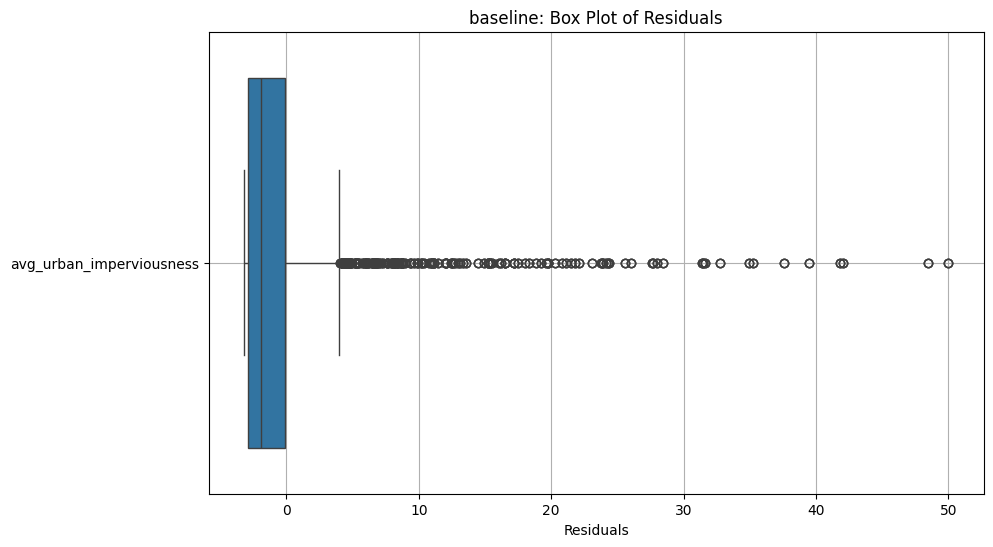

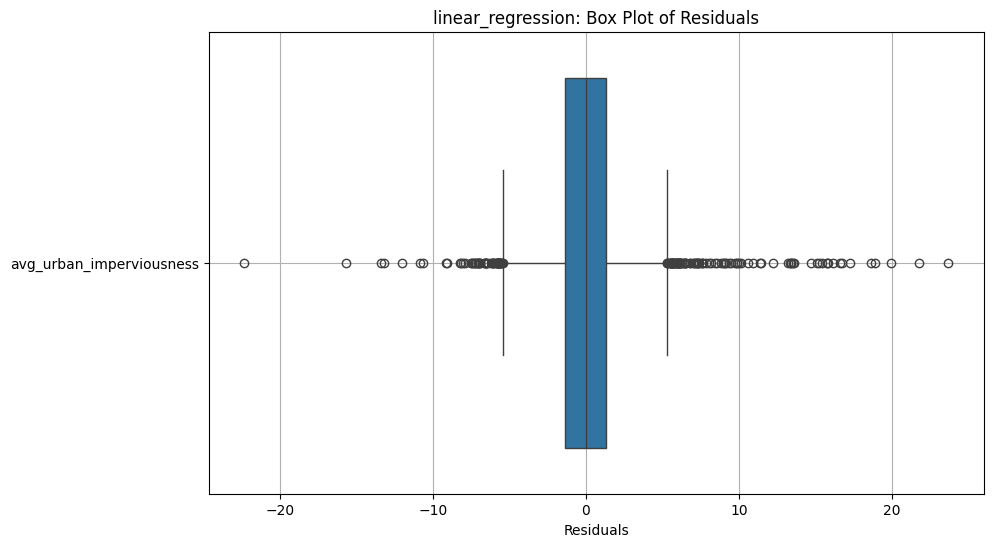

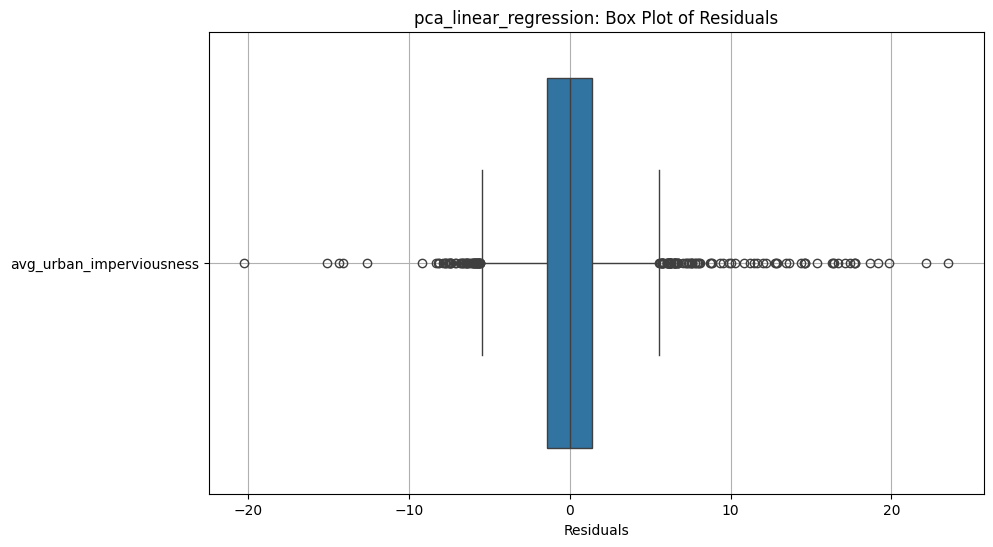

ValueError: Unable to coerce to Series, length must be 1: given 4467

In [42]:
# Generate box plots for all models
for model_name, model in models.items():
    if model_name == 'pca_linear_regression':
        y_pred = model.predict(X_test_pca)
    elif model_name == 'baseline':  
        y_pred = np.full_like(y_test, y_train.mean().values, dtype=np.float64)
    else:
        y_pred = model.predict(X_test)
    plot_residuals_boxplot(y_test, y_pred, title=f"{model_name}: Box Plot of Residuals")

In [43]:
# Generate a summary DataFrame with all metrics
metrics_summary = {
    'Model': [],
    'RMSE': [],
    'MAE': [],
    'R^2': [],
    'sMAPE': []
}

for model_name, model in models.items():
    if model_name == 'pca_linear_regression':
        y_pred = model.predict(X_test_pca)
    elif model_name == 'baseline':  
        y_pred = np.full_like(y_test, y_train.mean().values, dtype=np.float64)
    else:
        y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    smape_value = smape(y_test.values.ravel(), y_pred)

    metrics_summary['Model'].append(model_name)
    metrics_summary['RMSE'].append(rmse)
    metrics_summary['MAE'].append(mae)
    metrics_summary['R^2'].append(r2)
    metrics_summary['sMAPE'].append(smape_value)

# Create a DataFrame for summary
metrics_df = pd.DataFrame(metrics_summary)
print(metrics_df)


                   Model      RMSE       MAE       R^2       sMAPE
0               baseline  5.738143  3.271424 -0.000176  107.464087
1      linear_regression  2.584719  1.775789  0.797063  136.800186
2  pca_linear_regression  2.665474  1.847771  0.784184  137.669845
3       lasso_regression  2.553823  1.734728  0.801886  103.561804
4               lightgbm  2.598562  1.393581  0.794884   80.237505
